# **1. Import Library**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow import keras

from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support

# **2. Data Loading**

Untuk dapat mengambil dataset dari Kaggle, perlu dilakukan konfigurasi kredensial API Kaggle di Google Colab. Kaggle menyediakan API yang memungkinkan akses langsung ke dataset mereka tanpa perlu mengunduhnya secara manual.

Proses ini dilakukan dengan mengunggah file kaggle.json yang berisi kredensial API yang diunduh dari halaman akun Kaggle.

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"valensiaelsakurnia","key":"c4287404537f6b82f7d127b79d980513"}'}

In [3]:
# Hapus semua folder yang berpotensi bentrok
!rm -rf "book-recommendation-dataset.zip"
!rm -rf "Books.csv"
!rm -rf "Ratings.csv"
!rm -rf "Users.csv"

# Setup kredensial Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset Anemia Dataset
!kaggle datasets download -d arashnic/book-recommendation-dataset

# Unzip file dataset
!unzip book-recommendation-dataset.zip

# Hapus semua folder yang tidak dibutuhkan
!rm -rf "classicRec.png"
!rm -rf "recsys_taxonomy2.png"
!rm -rf "DeepRec.png"

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
  0% 0.00/24.3M [00:00<?, ?B/s]
100% 24.3M/24.3M [00:00<00:00, 1.01GB/s]
Archive:  book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    


Dengan kredensial yang telah disiapkan, kode *!kaggle datasets download -d arashnic/book-recommendation-dataset* digunakan untuk mengunduh dataset yang berjudul "book-recommendation-dataset" dari Kaggle.

Setelah itu, file yang diunduh (dalam format ZIP) diekstrak menggunakan perintah *!unzip book-recommendation-dataset.zip*. Ekstraksi ini bertujuan untuk mengakses file data dalam format CSV yang ada di dalamnya.

Setelah itu, kita perlu mengubah dataset yang diunduh dalam format CSV ke dalam variabel DataFrame.

In [4]:
# Membaca dataset
books = pd.read_csv("Books.csv")
users = pd.read_csv("Users.csv")
ratings = pd.read_csv("Ratings.csv")

<ipython-input-4-7688e75ba33e>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("Books.csv")


# **3. Data Understanding**

## **Books.csv**

Pertama kita lihat terlebih dahulu struktur books.csv dengan fungsi `head()` dan `info()`

In [5]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
# Menampilkan informasi tentang dataset
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Berdasarkan hasil pemanggilan fungsi books.info(), dataset Books.csv terdiri dari 271.360 entri dengan 8 kolom. Detail tiap kolom:
- ISBN: Nomor ISBN yang digunakan untuk mengidentifikasi buku.
- Book-Title: Judul buku.
- Book-Author: Penulis buku (hanya penulis pertama jika ada lebih dari satu).
- Year-Of-Publication: Tahun terbit buku.
- Publisher: Penerbit buku.
- Image-URL-S: URL gambar sampul buku dalam ukuran kecil.
- Image-URL-M: URL gambar sampul buku dalam ukuran sedang.
- Image-URL-L: URL gambar sampul buku dalam ukuran besar.

Untuk keperluan analisis dan pembuatan sistem rekomendasi, tipe data pada kolom `Year-Of-Publication` diubah menjadi `int64` agar dapat digunakan secara numerik. Selain itu, kolom `Image-URL-S`, `Image-URL-M`, dan `Image-URL-L` dihapus karena hanya berisi URL gambar dan tidak relevan dalam konteks content-based filtering maupun collaborative filtering.

Selanjutnya kita memeriksa apakah ada missing value.

In [7]:
# Memeriksa missing value
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


Terdapat 3 missing value pada `Image-URL-L`, tetap dapat diabaikan karena nantinya kolom akan di-drop. Selain itu ada juga missing value pada `Book-Author` dan `Publisher` yang memerlukan penanganan imputasi karena kolom ini digunakan pada pembuatan sistem rekomendasi

Cek di data ke berapa nilai null untuk memudahkan penanganan missing value atau imputasi data

In [8]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


In [9]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


Setelah itu, dilakukan pengecekan pada kolom `Year-Of-Publication`

In [10]:
# Mendapatkan nilai unik dan mengurutkannya sebagai string
uniqe_years = sorted(books['Year-Of-Publication'].unique(), key=str)

# Menentukan jumlah item per baris
items_per_row = 20

# Menampilkan tahun yang sudah diurutkan dalam format grid
for i in range(0, len(uniqe_years), items_per_row):
    print(" ".join(str(year) for year in uniqe_years[i:i+items_per_row]))

0 0 1376 1378 1806 1897 1900 1900 1901 1902 1904 1906 1908 1909 1910 1911 1911 1914 1917 1919
1920 1920 1921 1922 1923 1923 1924 1924 1925 1926 1926 1927 1927 1928 1929 1930 1930 1931 1931 1932
1932 1933 1933 1934 1935 1936 1936 1937 1938 1938 1939 1939 1940 1940 1941 1941 1942 1942 1943 1943
1944 1944 1945 1945 1946 1946 1947 1947 1948 1948 1949 1949 1950 1950 1951 1951 1952 1952 1953 1953
1954 1954 1955 1955 1956 1956 1957 1957 1958 1958 1959 1959 1960 1960 1961 1961 1962 1962 1963 1963
1964 1964 1965 1965 1966 1966 1967 1967 1968 1968 1969 1969 1970 1970 1971 1971 1972 1972 1973 1973
1974 1974 1975 1975 1976 1976 1977 1977 1978 1978 1979 1979 1980 1980 1981 1981 1982 1982 1983 1983
1984 1984 1985 1985 1986 1986 1987 1987 1988 1988 1989 1989 1990 1990 1991 1991 1992 1992 1993 1993
1994 1994 1995 1995 1996 1996 1997 1997 1998 1998 1999 1999 2000 2000 2001 2001 2002 2002 2003 2003
2004 2004 2005 2005 2006 2008 2010 2011 2011 2012 2020 2020 2021 2024 2026 2030 2030 2037 2038 2050
DK Pub

Dari hasil pemeriksaan pada kolom Year-Of-Publication, ditemukan dua entri yang tidak sesuai dengan format yang diharapkan, di mana kolom ini berisi nama penerbit seperti "DK Publishing Inc" dan "Gallimard", padahal kolom tersebut seharusnya hanya berisi tahun penerbitan buku

In [11]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [12]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


Setelah pengecekan, terdapat kesalahan input yang menyebabkan data pada beberapa kolom tergeser. Tiga entri pada kolom `Book-Author` berisi gabungan antara judul buku dan nama penulis. Perlu dilakukan pemisahan data dan perbaikan nilai pada kolom `Year-Of-Publication` agar formatnya konsisten dan valid untuk analisis.


Selanjutnya, kita memeriksa apakah terdapat karakter non-alfanumerik pada kolom ISBN dalam data rating.

In [13]:
# Inisialisasi flag dan daftar kosong
flag = 0
k = []

# Menentukan pola ekspresi reguler untuk karakter non-alfanumerik
pattern = "[^A-Za-z0-9]"

# Mengecek setiap nilai ISBN dalam data books
for isbn in ratings['ISBN']:
    # Mencari karakter yang tidak sesuai dengan pola alfanumerik
    result = re.search(pattern, isbn)

    # Jika ditemukan karakter non-alfanumerik
    if result:
        flag = 1

# Jika flag bernilai 1, berarti ditemukan karakter non-alfanumerik
if flag == 1:
    print("False")
else:
    print("True")

False


Dari hasil pengecekan, menggunakan flag, ditemukan bahwa ada karakter non-alfanumerik yang tidak sesuai dengan format yang diharapkan, sehingga perlu dilakukan perbaikan pada data tersebut.

Setelah itu, kita periksa apakah ada data yang duplikat

In [14]:
# Memeriksa duplikasi data
jumlah_duplikat = books.duplicated().sum()
print(f"Jumlah baris duplikat: {jumlah_duplikat}")

Jumlah baris duplikat: 0


Pada dataset ini, tidak ditemukan duplikat.

## **Users.csv**

Pertama kita lihat terlebih dahulu struktur users.csv dengan fungsi `head()` dan `info()`

In [15]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [16]:
# Menampilkan informasi tentang dataset
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Dataset Users memiliki kolom Location yang menggabungkan informasi kota, negara bagian, dan negara dalam satu kolom seperti "nyc, new york, usa". Meskipun kolom ini tidak digunakan dalam model rekomendasi, pemisahan menjadi City, State, dan Country penting untuk menjaga konsistensi data dan memudahkan pengelolaan di masa depan.

Berdasarkan hasil pemanggilan fungsi users.info(), dataset Books.csv terdiri dari 278.858 entri dengan 3 kolom. Detail tiap kolom:
- User-ID: ID pengguna yang telah dianonimkan.
- Location: Lokasi pengguna.
- Age: Umur pengguna.

Dataset terdiri dari kolom User-ID dengan tipe int64, Location dengan tipe data object, dan Age dengan tipe float64, yang sudah sesuai dengan jenis data masing-masing.

Selanjutnya kita memeriksa apakah ada missing value.

In [17]:
# Memeriksa missing value
users.isnull().sum()

,0
User-ID,0
Location,0
Age,110762


Ditemukan bahwa kolom Age memiliki 110,762 entri yang kosong. Meskipun kolom Age tidak digunakan dalam model rekomendasi berbasis Content-Based Filtering dan Collaborative Filtering, penting untuk menangani nilai yang hilang pada kolom ini untuk menjaga konsistensi data

Selanjutnya, dilakukan pengecekan lebih lanjut pada kolom Age

In [18]:
# Mendapatkan nilai unik umur dan mengurutkannya
unique_ages = sorted(users['Age'].unique())

# Menentukan jumlah item per baris
items_per_row = 20

# Menampilkan usia yang sudah diurutkan dalam format grid dengan 20 nilai per baris
for i in range(0, len(unique_ages), items_per_row):
    print(" ".join(str(age) for age in unique_ages[i:i+items_per_row]))

nan 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0
19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0
39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0
59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0
79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0
99.0 100.0 101.0 102.0 103.0 104.0 105.0 106.0 107.0 108.0 109.0 110.0 111.0 113.0 114.0 115.0 116.0 118.0 119.0 123.0
124.0 127.0 128.0 132.0 133.0 136.0 137.0 138.0 140.0 141.0 143.0 146.0 147.0 148.0 151.0 152.0 156.0 157.0 159.0 162.0
168.0 172.0 175.0 183.0 186.0 189.0 199.0 200.0 201.0 204.0 207.0 208.0 209.0 210.0 212.0 219.0 220.0 223.0 226.0 228.0
229.0 230.0 231.0 237.0 239.0 244.0


Berdasarkan hasil pengecekan data pada kolom Age, dapat dilihat bahwa bahwa terdapat nilai NaN (missing values) dalam data usia. Setelah disortir, terdapat berbagai rentang usia yang tercatat dalam dataset. Rentang usia ini bervariasi dari 0 hingga 244. Ada beberapa nilai usia yang lebih tinggi (lebih dari 80), yang bisa jadi merupakan entri yang tidak valid atau mungkin hasil kesalahan input

Setelah itu, kita periksa apakah ada data yang duplikat.

In [19]:
# Memeriksa duplikasi data
jumlah_duplikat = users.duplicated().sum()
print(f"Jumlah baris duplikat: {jumlah_duplikat}")

Jumlah baris duplikat: 0


Tidak ditemukan data duplikat pada users.csv

## **Ratings.csv**

Pertama kita lihat terlebih dahulu struktur ratings.csv dengan fungsi `head()` dan `info()`

In [20]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [21]:
# Menampilkan informasi tentang dataset
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Berdasarkan hasil pemanggilan fungsi users.info(), dataset Books.csv terdiri dari 1.149.780 entri dengan 3 kolom. Detail tiap kolom:
- User-ID: ID pengguna yang memberikan rating pada buku.
- ISBN: ISBN buku yang diberi rating.
- Book-Rating: Rating yang diberikan oleh pengguna, dengan rentang nilai 1-10 (nilai 0 menandakan rating implisit).

Tipe data User-ID dan Book-Rating sudah int64 sesuai kebutuhan, sedangkan ISBN bertipe object yang tepat karena berisi data alfanumerik.

Selanjutnya kita memeriksa apakah ada missing value.

In [22]:
# Memeriksa missing value
ratings.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


Tidak ditemukan missing value pada dataset ratings.csv

Selanjutnya, kita memeriksa apakah terdapat karakter non-alfanumerik pada kolom ISBN dalam data rating.

In [23]:
# Inisialisasi flag dan daftar kosong
flag = 0
k = []

# Menentukan pola ekspresi reguler untuk karakter non-alfanumerik
pattern = "[^A-Za-z0-9]"

# Mengecek setiap nilai ISBN dalam data ratings
for isbn in ratings['ISBN']:
    # Mencari karakter yang tidak sesuai dengan pola alfanumerik
    result = re.search(pattern, isbn)

    # Jika ditemukan karakter non-alfanumerik
    if result:
        flag = 1

# Jika flag bernilai 1, berarti ditemukan karakter non-alfanumerik
if flag == 1:
    print("False")
else:
    print("True")


False


Dari hasil pengecekan, menggunakan flag, ditemukan bahwa ada karakter non-alfanumerik yang tidak sesuai dengan format yang diharapkan, sehingga perlu dilakukan perbaikan pada data tersebut.

Selanjutnya, dilakukan pengecekan deskripsi statistik data dengan fitur `describe()`.

In [24]:
# Mengatur pandas untuk menampilkan angka dalam format float standar
pd.set_option('display.float_format', '{:,.0f}'.format)

# Menampilkan deskripsi statistik dari DataFrame 'ratings'
ratings.describe()

,User-ID,Book-Rating
count,"1,149,780","1,149,780"
mean,"140,386",3
std,"80,562",4
min,2,0
25%,"70,345",0
50%,"141,010",0
75%,"211,028",7
max,"278,854",10


Kolom Book-Rating memiliki nilai antara 0 sampai 10, dengan 0 menandakan tidak ada rating (interaksi implisit). Untuk meningkatkan kualitas model rekomendasi, data dengan rating 0 sebaiknya dihapus agar hanya interaksi nyata yang digunakan dalam proses.

Setelah itu, kita periksa apakah ada data yang duplikat.

In [25]:
# Memeriksa duplikasi data
jumlah_duplikat = ratings.duplicated().sum()
print(f"Jumlah baris duplikat: {jumlah_duplikat}")

Jumlah baris duplikat: 0


Tidak ada duplikasi data pada ratings.csv

# **4. Exploratory Data Analysis**

Selanjutnya, kita akan melakukan proses analisis data dengan teknik Univariate Analysis.

## **Univariate Analysis**

Pertama, kita akan melihat distribusi jumlah buku berdasarkan penulis

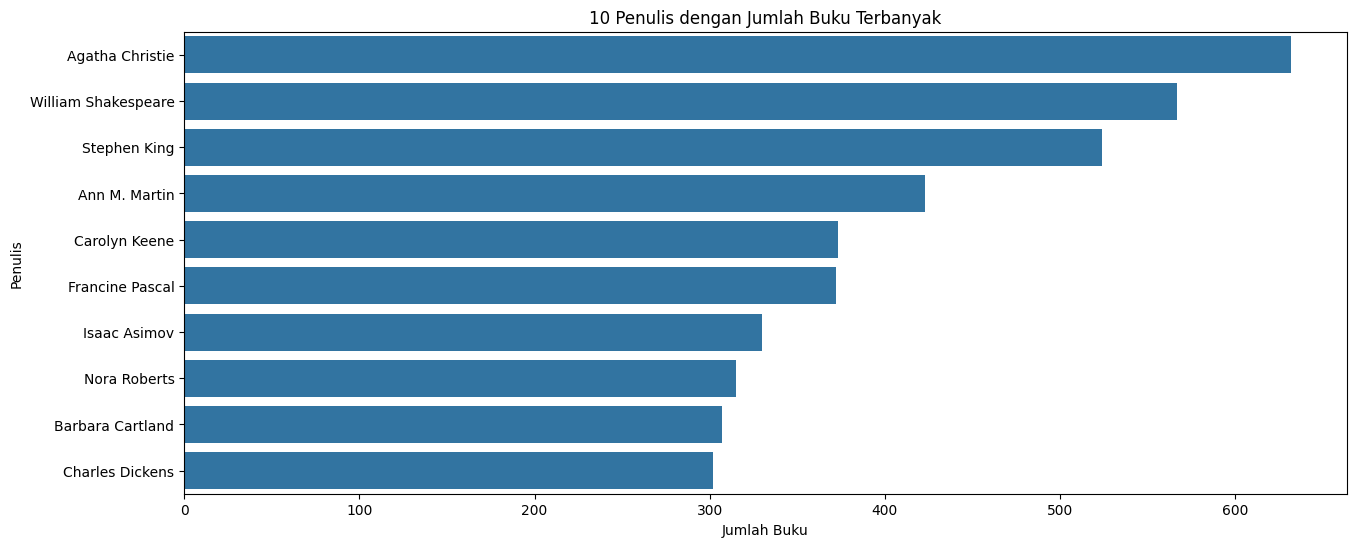

In [ ]:
# Mengatur ukuran figure untuk plot
plt.figure(figsize=(15, 6))

# Menampilkan jumlah buku berdasarkan penulis, mengurutkan berdasarkan jumlah buku terbanyak
sns.countplot(y="Book-Author", data=books, order=books['Book-Author'].value_counts().index[:10])

# Menambahkan judul dan label pada plot
plt.title("10 Penulis dengan Jumlah Buku Terbanyak")
plt.xlabel("Jumlah Buku")
plt.ylabel("Penulis")

# Menampilkan plot
plt.show()

Grafik menunjukkan 10 penulis dengan jumlah buku terbanyak dalam dataset. Agatha Christie menduduki posisi teratas dengan lebih dari 600 judul buku, diikuti oleh William Shakespeare dan Stephen King dengan jumlah buku mendekati 500-600 judul. Penulis lain seperti Ann M. Martin, Carolyn Keene, dan Isaac Asimov juga memiliki jumlah buku yang signifikan (sekitar 300-400 judul). Hal ini menunjukkan bahwa karya-karya dari penulis produktif ini sangat dominan dalam dataset, yang dapat memengaruhi rekomendasi buku, terutama dalam metode content-based filtering dan collaborative filtering karena popularitas dan volume karya mereka yang besar.


Selanjutnya, kita akan melihat distribusi jumlah buku berdasarkan penerbit

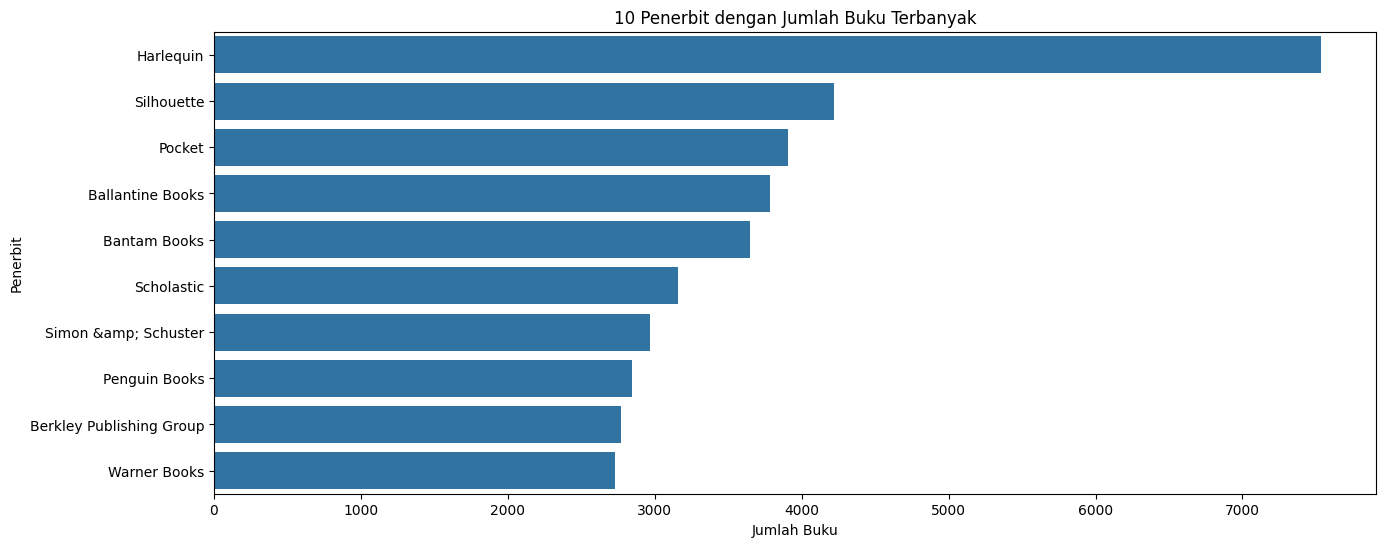

In [26]:
# Mengatur ukuran figure untuk plot
plt.figure(figsize=(15, 6))

# Menampilkan jumlah buku berdasarkan penerbit, mengurutkan berdasarkan jumlah buku terbanyak
sns.countplot(y="Publisher", data=books, order=books['Publisher'].value_counts().index[:10])

# Menambahkan judul dan label pada plot
plt.title("10 Penerbit dengan Jumlah Buku Terbanyak")
plt.xlabel("Jumlah Buku")
plt.ylabel("Penerbit")

# Menampilkan plot
plt.show()

Harlequin mendominasi jumlah buku jauh lebih banyak dibanding penerbit lain seperti Silhouette, Pocket, dan Ballantine Books yang jumlahnya relatif seimbang namun jauh lebih sedikit. Dominasi ini berpotensi memengaruhi fokus analisis dan sistem rekomendasi, terutama pada content-based dan collaborative filtering.

Selanjutnya, dilakukan visualisasi distribusi usia pengguna

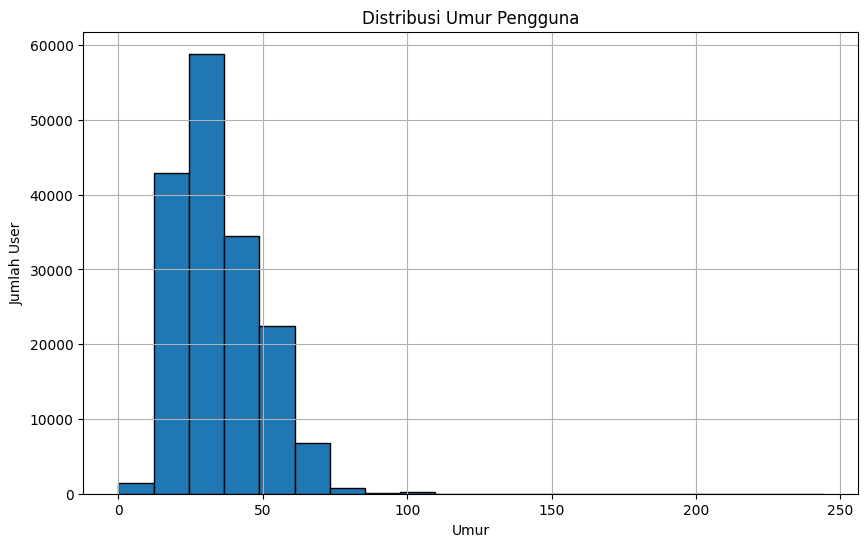

In [ ]:
# Menentukan ukuran figure untuk plot
plt.figure(figsize=(10, 6))

# Membuat histogram untuk kolom 'Age' tanpa menghapus nilai yang hilang
plt.hist(users['Age'], bins=20, edgecolor='black')

# Menambahkan judul dan label pada plot
plt.title('Distribusi Umur Pengguna')
plt.xlabel('Umur')
plt.ylabel('Jumlah User')

# Menambahkan grid untuk memudahkan pembacaan
plt.grid(True)

# Menampilkan plot
plt.show()

Distribusi umur menunjukkan data tidak valid di rentang dekat 0 dan di atas 100 tahun. Data invalid ini dapat memengaruhi akurasi rekomendasi jika umur dipakai, sehingga perlu penanganan dengan imputasi menggunakan nilai rata-rata.

Dilanjutkan dengan visualisasi distribusi rating

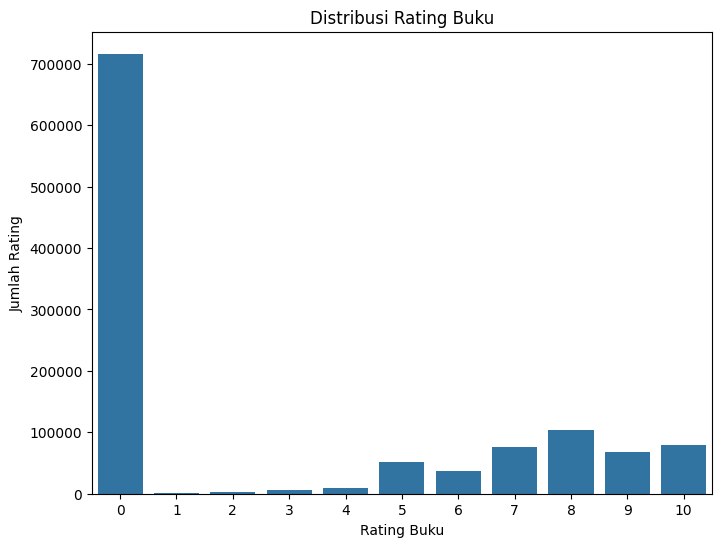

In [ ]:
# Menentukan ukuran figure untuk plot
plt.figure(figsize=(8, 6))

# Membuat countplot untuk distribusi rating buku
sns.countplot(x="Book-Rating", data=ratings)

# Menambahkan judul dan label pada plot
plt.title('Distribusi Rating Buku')
plt.xlabel('Rating Buku')
plt.ylabel('Jumlah Rating')

# Menampilkan plot
plt.show()

Distribusi rating didominasi oleh nilai 0, menandakan banyak interaksi implisit. Rating 0 perlu dihapus agar fokus pada preferensi pengguna nyata (1–10), menghasilkan dataset lebih kecil tapi lebih relevan untuk collaborative filtering.


Sebelum analisis lebih lanjut, kita harus menggabungkan dataset ratings dan books terlebih dahulu dengan membentuk DataFrame baru khusus untuk analisis saja

In [28]:
dataset_analysis = pd.merge(ratings, books, on='ISBN')

Kita akan memahami hubungan popularitas pengguna terhadap buku tertentu.

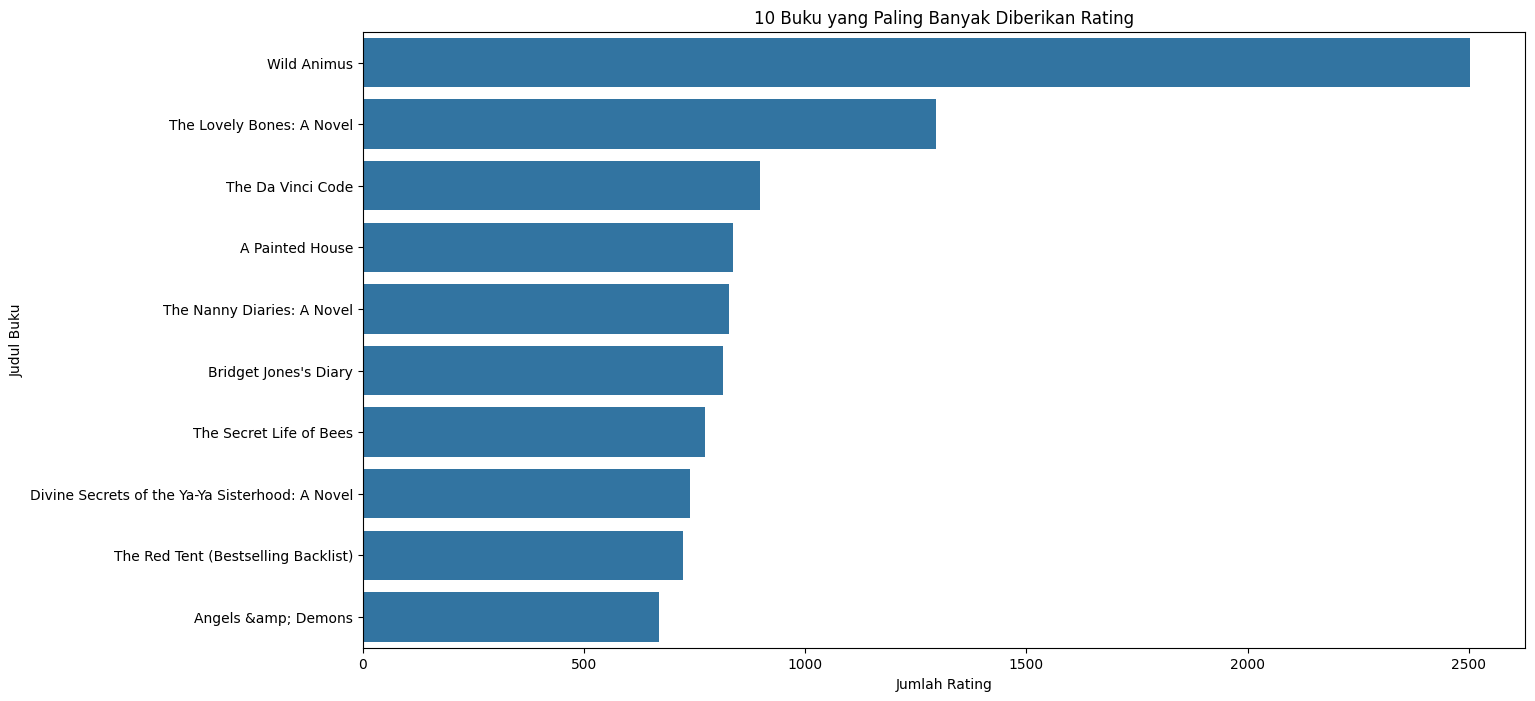

In [29]:
# Mengelompokkan berdasarkan Book-Title dan menghitung jumlah rating per buku
top_books = dataset_analysis['Book-Title'].value_counts().head(10)

# Mengatur ukuran figure untuk plot
plt.figure(figsize=(15, 8))

# Membuat plot batang horizontal untuk 10 buku yang paling banyak diberi rating
sns.barplot(x=top_books.values, y=top_books.index)

# Menambahkan judul dan label
plt.title("10 Buku yang Paling Banyak Diberikan Rating")
plt.xlabel("Jumlah Rating")
plt.ylabel("Judul Buku")

# Menampilkan plot
plt.show()

Visualisasi Buku yang Paling Banyak Diberikan Rating mengidentifikasi 'Wild Animus' sebagai buku yang menerima rating terbanyak secara signifikan, diikuti oleh 'The Lovely Bones: A Novel'. Buku-buku dengan jumlah rating tinggi ini mengindikasikan popularitas yang besar di kalangan pengguna dan dapat menjadi rekomendasi yang kuat dalam sistem.

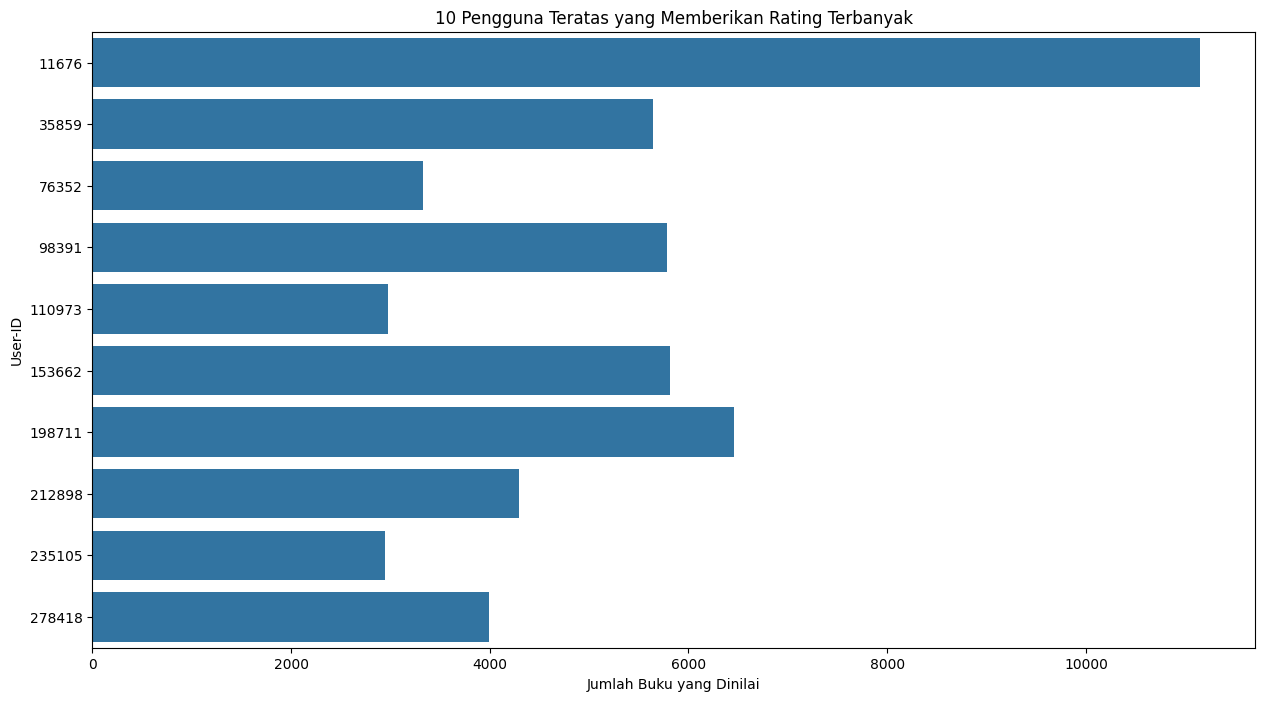

In [ ]:
# Mengambil 10 pengguna teratas yang memberikan rating terbanyak
top_10_users = dataset_analysis['User-ID'].value_counts().head(10)

# Mengatur ukuran figure untuk plot
plt.figure(figsize=(15, 8))

# Membuat plot batang horizontal untuk 10 pengguna teratas berdasarkan jumlah buku yang dinilai terbanyak
sns.barplot(x=top_10_users.values, y=top_10_users.index, orient='h')

# Menambahkan judul dan label
plt.title("10 Pengguna Teratas yang Memberikan Rating Terbanyak")
plt.xlabel("Jumlah Buku yang Dinilai")
plt.ylabel("User-ID")

# Menampilkan plot
plt.show()

Pengguna ID 11676 memberikan rating paling banyak, menyediakan data preferensi yang kaya untuk collaborative filtering. Data ini membantu mengenali pola kesamaan antar pengguna dan meningkatkan rekomendasi.

# **5. Data Preparation**

## **Penghapusan Kolom yang Tidak Diperlukan (_dropping coloumns_)**

In [30]:
# Drop URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

## **Penanganan Missing Value**

Berdasarkan hasil pengecekan pada data understanding, terdapat missing value pada dataset books dan users yang perlu penanganan.

**Books**

In [31]:
# Menetapkan nilai 'Other' pada kolom 'Book-Author' di baris 187689 dan 118033
books.loc[187689, 'Book-Author'] = 'Other'
books.loc[118033, 'Book-Author'] = 'Other'

# Menetapkan nilai 'Other' pada kolom 'Publisher' di baris 128890 dan 129037
books.loc[128890, 'Publisher'] = 'Other'
books.loc[129037, 'Publisher'] = 'Other'

**Users**

In [32]:
# Menghitung rata-rata usia (mean) dari kolom 'Age', mengabaikan nilai NaN
mean_age = users['Age'].mean()

# Mengganti nilai NaN atau data yang tidak valid (misalnya nilai negatif) dengan rata-rata usia
users['Age'] = users['Age'].apply(lambda x: mean_age if pd.isna(x) else x)

Penanganan missing value dilakukan dengan imputasi: nilai 'Other' untuk kolom `Book-Author` dan `Publisher` pada dataset books, serta imputasi rata-rata untuk kolom 'Age' pada dataset users. Langkah ini penting agar data siap digunakan dalam sistem rekomendasi.

## **Standarisasi Format**

Pada tahap ini dilakukan standarisasi format diterapkan pada kolom ISBN yang terdapat baik dalam dataset books maupun ratings. Proses ini melibatkan pengubahan seluruh karakter dalam kolom 'ISBN' menjadi huruf kapital menggunakan fungsi `.str.upper()` pada kedua dataset.

In [33]:
books['ISBN'] = books['ISBN'].str.upper()

In [34]:
ratings['ISBN'] = ratings['ISBN'].str.upper()

## **Penanganan Invalid Data**

Pada Data Understanding ditemukan banyak invalid data yang perlu diperbaiki. Berikut adalah penanganannya.

**Mengatasi Kesalahan Data yang Tergeser**

In [35]:
# Memperbarui informasi di baris 209538
books.loc[209538, 'Publisher'] = 'DK Publishing Inc'
books.loc[209538, 'Year-Of-Publication'] = 2000
books.loc[209538, 'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.loc[209538, 'Book-Author'] = 'Michael Teitelbaum'

# Memperbarui informasi di baris 221678
books.loc[221678, 'Publisher'] = 'DK Publishing Inc'
books.loc[221678, 'Year-Of-Publication'] = 2000
books.loc[221678, 'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.loc[221678, 'Book-Author'] = 'James Buckley'

# Memperbarui informasi di baris 220731
books.loc[220731, 'Publisher'] = 'Gallimard'
books.loc[220731, 'Year-Of-Publication'] = 2003
books.loc[220731, 'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers'
books.loc[220731, 'Book-Author'] = 'Jean-Marie Gustave Le Clézio'

In [36]:
# Menampilkan hasil pembaruan
books.loc[[209538, 221678, 220731]]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc
220731,2070426769,Peuple du ciel - Suivi de Les bergers,Jean-Marie Gustave Le Clézio,2003,Gallimard


Dilakukan pembaruan data secara manual (explicit value replacement) pada baris tertentu di dataset books untuk memperbaiki informasi yang salah, seperti judul, penulis, penerbit, dan tahun publikasi. Langkah ini penting agar data akurat dan dapat diandalkan dalam analisis dan sistem rekomendasi.

**Mengubah Invalid Years pada "Years-of-Publication"**

Tipe data Year-Of-Publication diubah menjadi tipe integer untuk memastikan bahwa tahun publikasi dapat diolah dengan benar dalam analisis numerik

In [37]:
# Mengonversi 'Year-Of-Publication' menjadi tipe data integer
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [38]:
# Mengganti tahun yang tidak valid (tahun 0 atau lebih besar dari 2025) dengan mode tahun
mode_year = books['Year-Of-Publication'].mode()[0]

# Terapkan perubahan pada kolom 'Year-Of-Publication'
books['Year-Of-Publication'] = books['Year-Of-Publication'].apply(
    lambda x: mode_year if x == 0 or x > 2025 else x
)

Dilakukan juga imputasi nilai tidak valid (misalnya 0 atau >2025) dengan nilai **mode**. Langkah ini dilakukan menghindari kesalahan interpretasi.


**Menghapus Karakter Tidak Valid pada Kolom ISBN**

Selanjutnya, dilakukan penghapusan karakter tidak valid pada kolom 'ISBN' untuk memastikan hanya karakter alfanumerik yang tersisa

In [39]:
# Fungsi untuk membersihkan ISBN dan menghapus karakter selain huruf dan angka
def clean_isbn(isbn):
    # Menghapus semua karakter selain huruf dan angka
    return re.sub(r'[^A-Za-z0-9]', '', isbn)

In [40]:
# Mengaplikasikan pembersihan ke kolom ISBN pada dataset books
books['ISBN'] = books['ISBN'].apply(lambda x: clean_isbn(x))

# Mengecek apakah ISBN sekarang valid (hanya terdiri dari huruf dan angka)
flag = 0
for x in books['ISBN']:
    if re.search("[^A-Za-z0-9]", x):
        flag = 1
        break

if flag == 1:
    print("False: ISBN contains invalid characters after cleaning")
else:
    print("True: All ISBNs are valid")

True: All ISBNs are valid


In [41]:
# Mengaplikasikan pembersihan ke kolom ISBN pada dataset ratings
ratings['ISBN'] = ratings['ISBN'].apply(lambda x: clean_isbn(x))

# Mengecek apakah ISBN sekarang valid (hanya terdiri dari huruf dan angka)
flag = 0
for x in ratings['ISBN']:
    if re.search("[^A-Za-z0-9]", x):
        flag = 1
        break

if flag == 1:
    print("False: ISBN contains invalid characters after cleaning")
else:
    print("True: All ISBNs are valid")

True: All ISBNs are valid


 Setelah dilakukan pembersihan, dilakukan pengecekan ulang. Hasil dari pengecekan ulang menunjukkan data ISBN sudah valid (terdiri data data alfanumerik). Langkah ini penting untuk menjaga format standar ISBN, memfasilitasi pencocokan antar dataset, dan meningkatkan akurasi identifikasi buku dalam sistem rekomendasi.

**Mengubah Nilai Invalid Age**

Selanjutnya, penanganan nilai invalid untuk kolom 'Age', digunakan teknik imputasi dengan nilai rata-rata atau mean imputation untuk mengganti nilai-nilai usia yang di luar batas wajar (kurang dari 10 atau lebih dari 80 tahun).

In [42]:
# Mengganti nilai yang lebih besar dari 80 atau lebih kecil dari 10 dengan rata-rata usia
users['Age'] = users['Age'].apply(lambda x: mean_age if x < 10 or x > 80 else x)

**Memisahkan Lokasi (City, State, Country)**

Selanjutnya, dilakukan ekstraksi dan pemisahan data pada kolom 'Location' menjadi kolom 'City', 'State', dan 'Country'. Langkah ini bertujuan untuk memperoleh informasi geografis yang lebih terstruktur guna mendukung analisis preferensi pengguna berdasarkan lokasi.


In [43]:
# Membagi data lokasi menjadi kota, negara bagian, dan negara
location_split = users.Location.str.split(', ')

# Inisialisasi list untuk menyimpan hasil dan hitung entri yang tidak valid
kota = []
negara_bagian = []
negara = []
count_no_state = 0
count_no_country = 0

# Iterasi untuk memproses setiap entri lokasi
for item in location_split:
    # Proses kota
    if item[0] in (' ', '', 'n/a', ','):
        kota.append('other')
    else:
        kota.append(item[0].lower())

    # Proses negara bagian dan negara
    if len(item) < 2:
        negara_bagian.append('other')
        negara.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if item[1] in (' ', '', 'n/a', ','):
            negara_bagian.append('other')
            count_no_state += 1
        else:
            negara_bagian.append(item[1].lower())

        if len(item) < 3:
            negara.append('other')
            count_no_country += 1
        else:
            if item[2] in (' ', '', 'n/a', ','):
                negara.append('other')
                count_no_country += 1
            else:
                negara.append(item[2].lower())

# Menghapus kolom 'Location' dari DataFrame
users = users.drop('Location', axis=1)

# Menangani kasus kota yang diikuti oleh negara bagian, dan hanya mengambil kota
kota_temp = [ent.split('/')[0] for ent in kota]

# Membuat DataFrame baru untuk Kota, Negara Bagian, dan Negara
df_kota = pd.DataFrame(kota_temp, columns=['City'])
df_negara_bagian = pd.DataFrame(negara_bagian, columns=['State'])
df_negara = pd.DataFrame(negara, columns=['Country'])

# Menggabungkan DataFrame baru ke dalam DataFrame 'users'
users = pd.concat([users, df_kota], axis=1)
users = pd.concat([users, df_negara_bagian], axis=1)
users = pd.concat([users, df_negara], axis=1)

# Mencetak jumlah entri negara dan negara bagian yang tidak memiliki nilai
print(count_no_country)
print(count_no_state)

4666
16044


In [44]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


Setelah penanganan dapat dilihat bahwa kolom `Location` sudah diubah menjadi `City`, `State`, dan `Country`

**Menghapus Rating dengan Nilai 0**

Selanjutnya, dilakukan pembersihan data pada dataset ratings dengan melakukan data filtering pada kolom `Book-Rating` dengan menghapus nilai 0, karena dianggap sebagai interaksi implisit yang dapat menimbulkan noise. Langkah ini membantu memfokuskan analisis pada preferensi pengguna yang jelas dan eksplisit.

In [45]:
ratings = ratings[ratings['Book-Rating'] != 0]
ratings = ratings.reset_index(drop = True)

## **Menghapus Data Duplikat**

Selanjutnya dilakukan penanganan untuk duplikasi data. Sebelum itu, dilakukan pengecekan ulang terlebih dahulu dikarenakan setelah data cleaning kemungkinan akan ada perubahan duplikasi data.

In [46]:
# Memeriksa duplikasi data books
jumlah_duplikat = books.duplicated().sum()
print(f"Jumlah baris duplikat pada books: {jumlah_duplikat}")

# Memeriksa duplikasi data users
jumlah_duplikat = users.duplicated().sum()
print(f"Jumlah baris duplikat pada users: {jumlah_duplikat}")

# Memeriksa duplikasi data ratings
jumlah_duplikat = ratings.duplicated().sum()
print(f"Jumlah baris duplikat pada ratings: {jumlah_duplikat}")

Jumlah baris duplikat pada books: 314
Jumlah baris duplikat pada users: 0
Jumlah baris duplikat pada ratings: 2


Dapat dilihat bahwa terdapat 314 data duplikat pada books dan 2 data duplikat pada ratings yang kemudian perlu dihapus.

In [47]:
books = books.drop_duplicates()
ratings = ratings.drop_duplicates()

## **Merging Dataset**

Tahapan persiapan data selanjutnya melibatkan penggabungan dataset (merging) dan pengambilan sampel (sampling). Proses penggabungan dilakukan dengan menggunakan fungsi `pd.merge()` sebanyak dua kali.

In [48]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')

DataFrame books dan ratings digabungkan berdasarkan kolom 'ISBN' dengan metode 'inner', menghasilkan DataFrame dataset yang berisi hanya baris dengan nilai 'ISBN' yang sama di kedua DataFrame. Kemudian, DataFrame dataset ini digabungkan kembali dengan DataFrame users berdasarkan kolom 'User-ID' juga menggunakan metode 'inner'

 Setelah penggabungan, dilakukan pengambilan sampel (sampling) dengan menggunakan fungsi `dataset.sample(n=10000, random_state=42)` untuk memilih secara acak 10000 baris dari DataFrame dataset

In [49]:
#Ambil sample 10000 baris agar tidak memperberat proses komputasi
dataset = dataset.sample(n=10000, random_state=42)

Berikut adalah hasil dari merging dan sampling.

In [50]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 279631 to 232526
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ISBN                 10000 non-null  object 
 1   Book-Title           10000 non-null  object 
 2   Book-Author          10000 non-null  object 
 3   Year-Of-Publication  10000 non-null  int64  
 4   Publisher            10000 non-null  object 
 5   User-ID              10000 non-null  int64  
 6   Book-Rating          10000 non-null  int64  
 7   Age                  10000 non-null  float64
 8   City                 10000 non-null  object 
 9   State                10000 non-null  object 
 10  Country              10000 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 937.5+ KB


In [51]:
dataset.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
279631,0747407827,Deathday,Shaun Hutson,1990,Penguin Books (NZ) Ltd,270545,4,30,forbes,new south wales,australia
108901,0451169522,Misery,Stephen King,2004,Penguin USA (Paper),49109,5,38,west jordan,utah,usa
138021,1882180887,A Basic Guide to Archery (An Official U.S. Oly...,U.S. Olympic Committee,1997,Griffin Publishing Inc.,1848,7,22,bellingham,washington,usa
339824,0515112410,"The Dangerous Marriage (Camfield, No 123)",Barbara Cartland,1993,Jove Books,189835,5,35,honolulu,hawaii,usa
852,0971880107,Wild Animus,Rich Shapero,2004,Too Far,257069,7,15,newcastle,new south wales,australia


## **Persiapan Content-Based Filtering**

**Konversi Data dalam Bentuk List**

Langkah pertama adalah mengonversi data menjadi list, yang akan memudahkan kita dalam membuat dataframe baru atau mengolah data lebih lanjut. Dalam hal ini, kita akan mengonversi kolom-kolom seperti Book-Title, Book-Author, dan Publisher ke dalam list.

In [52]:
# Mengonversi data series ‘Book-Title’ menjadi dalam bentuk list
book_title = dataset['Book-Title'].tolist()

# Mengonversi data series ‘Book-Author’ menjadi dalam bentuk list
book_author = dataset['Book-Author'].tolist()

# Mengonversi data series ‘Publisher’ menjadi dalam bentuk list
publisher = dataset['Publisher'].tolist()

# Mengonversi data series ‘ISBN’ menjadi dalam bentuk list
isbn = dataset['ISBN'].tolist()

# Print panjang list untuk memastikan data dikonversi dengan benar
print(len(book_title))
print(len(book_author))
print(len(publisher))
print(len(isbn))

10000
10000
10000
10000


**Membuat DataFrame Baru**

Selanjutnya, kita akan membuat dictionary untuk menggabungkan data book_title, book_author, dan publisher menjadi satu DataFrame baru yang siap digunakan untuk model sistem rekomendasi berbasis konten.

In [53]:
# Membuat dictionary untuk data ‘book_title’, ‘book_author’, dan ‘publisher’
book_data = pd.DataFrame({
    'book_title': book_title,
    'book_author': book_author,
    'publisher': publisher
})

book_data.head()

,book_title,book_author,publisher
0,Deathday,Shaun Hutson,Penguin Books (NZ) Ltd
1,Misery,Stephen King,Penguin USA (Paper)
2,A Basic Guide to Archery (An Official U.S. Oly...,U.S. Olympic Committee,Griffin Publishing Inc.
3,"The Dangerous Marriage (Camfield, No 123)",Barbara Cartland,Jove Books
4,Wild Animus,Rich Shapero,Too Far


**Menghapus Duplikasi DataFrame Baru**

Selanjutnya, dilakukan penghapusan duplikasi pada DataFrame book_data dengan fokus pada kolom 'book_title'. Sebanyak 12.553 baris duplikat teridentifikasi dan dihapus. Hal ini penting karena satu buku dapat memiliki beberapa entri akibat adanya rating berbeda pada dataset awal.

In [54]:
jumlah_duplikat = book_data.duplicated().sum()
print(f"Jumlah baris duplikat: {jumlah_duplikat}")

Jumlah baris duplikat: 1569


In [55]:
book_data = book_data.drop_duplicates(subset=['book_title'])

**TF-IDF Vectorizer**

Pada langkah ini, kita akan menggunakan TF-IDF Vectorizer untuk mendapatkan representasi fitur penting dari setiap judul buku berdasarkan kategori atau fitur yang relevan. Di sini kita akan fokus pada kategori Book-Title dan Book-Author untuk membangun fitur.



In [ ]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')

# Melakukan perhitungan idf pada data 'Book-Title'
tf.fit(book_data['book_title'])

# Menampilkan fitur nama dari hasil perhitungan tf-idf
tf.get_feature_names_out()

array(['000', '000 englische', '000 english', ..., 'â¼terin der', 'â¼ã',
       'â¼ã das'], dtype=object)

Setelah menghitung IDF, kita dapat melakukan transformasi untuk menghasilkan matriks TF-IDF yang menggambarkan hubungan antara setiap judul buku.

In [ ]:
# Melakukan transformasi data 'Book-Title' menjadi matriks tf-idf
tfidf_matrix = tf.fit_transform(book_data['book_title'])

# Melihat ukuran matriks tf-idf
print(tfidf_matrix.shape)

(8146, 30407)


Untuk menghasilkan vektor tf-idf dalam bentuk matriks, gunakan fungsi todense().

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

**Mengubah Tipe Data Matriks TF-IDF**

Selanjutnya, matriks TF-IDF diubah tipe datanya menjadi float32 untuk mengoptimalkan penggunaan memori dan mempercepat proses komputasi tanpa mengurangi presisi signifikan.

In [ ]:
# Mengonversi matriks tf-idf ke tipe data float32
normalized_df = tfidf_matrix.astype(np.float32)

## **Persiapan Collaborative Filtering**

In [ ]:
# Membaca dataset
df = dataset
df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
279631,0747407827,Deathday,Shaun Hutson,1990,Penguin Books (NZ) Ltd,270545,4,30,forbes,new south wales,australia
108901,0451169522,Misery,Stephen King,2004,Penguin USA (Paper),49109,5,38,west jordan,utah,usa
138021,1882180887,A Basic Guide to Archery (An Official U.S. Oly...,U.S. Olympic Committee,1997,Griffin Publishing Inc.,1848,7,22,bellingham,washington,usa
339824,0515112410,"The Dangerous Marriage (Camfield, No 123)",Barbara Cartland,1993,Jove Books,189835,5,35,honolulu,hawaii,usa
852,0971880107,Wild Animus,Rich Shapero,2004,Too Far,257069,7,15,newcastle,new south wales,australia
...,...,...,...,...,...,...,...,...,...,...,...
67240,0446679364,The Future Homemakers of America,Laurie Graham,2002,Warner Books,268932,9,38,red deer,alberta,canada
97857,0399142495,Small Town Girl,LaVyrle Spencer,1997,Putnam Pub Group,16795,8,47,mechanicsville,maryland,usa
66430,0312924585,Silence of the Lambs,Thomas Harris,1991,St. Martin's Press,190335,5,35,lititz,pennsylvania,usa
291343,0451157036,Good Friday,Holt Robert,1988,Penguin Putnam~mass,250413,8,35,brooklyn,new york,usa


**Penghapusan Kolom untuk Menyederhanakan Dataset**

Kolom `Year-Of-Publication`, `Publisher`, `Age`, `City`, `State`, dan `Country` dihapus untuk menyederhanakan data dan fokus pada fitur yang relevan, sehingga meningkatkan efisiensi dan akurasi model rekomendasi.


In [ ]:
df = df.drop(['Year-Of-Publication','Publisher','Age','City','State','Country'], axis=1)

**Encoding Data**

Selanjutnya, dilakukan encoding `User-ID` dan `ISBN` ke integer untuk memudahkan pemrosesan oleh algoritma machine learning.

In [ ]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['User-ID'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [270545, 49109, 1848, 189835, 257069, 26516, 101851, 24301, 143909, 2103, 33974, 101589, 124818, 212002, 52584, 56959, 98391, 270629, 220042, 129074, 274808, 3728, 109901, 172116, 128835, 15602, 142357, 108182, 136916, 161101, 19582, 209756, 13552, 270713, 153662, 190185, 118484, 238624, 103150, 207825, 174216, 243236, 163973, 51918, 208566, 263163, 165308, 189747, 11676, 4149, 177458, 189139, 28451, 263777, 20462, 32084, 176875, 205487, 15408, 171846, 60050, 231857, 78834, 21955, 124597, 5543, 165914, 193560, 153513, 15721, 48217, 128669, 12702, 30276, 204501, 95593, 132361, 234828, 156100, 127168, 141322, 31315, 125774, 100459, 261886, 77676, 216012, 190119, 109955, 217106, 2893, 2977, 4092, 264828, 90616, 175493, 261768, 5920, 268110, 57412, 98628, 12538, 643, 76352, 151589, 187574, 275075, 121606, 278418, 170724, 114368, 233445, 192101, 236994, 81263, 154543, 12824, 130474, 215953, 104113, 175752, 13273, 33818, 205728, 92106, 56307, 23872, 252719, 44091, 229313, 96357

In [ ]:
book_ids = df['ISBN'].unique().tolist()
print('list ISBN: ', book_ids)

# Melakukan proses encoding isbn
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
print('encoded ISBN : ', book_to_book_encoded)

# Melakukan proses encoding angka ke isbn
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}
print('encoded angka ke ISBN: ', book_encoded_to_book)

list ISBN:  ['0747407827', '0451169522', '1882180887', '0515112410', '0971880107', '0373258224', '0877735441', '0553201743', '3453162218', '014029645X', '038550120X', '3453108574', '0933256671', '3404142780', '0312283407', '0670831727', '1931742138', '094239156X', '0446609323', '0449211991', '0689806574', '0553574671', '0743457358', '0679732411', '0140092323', '0312291639', '0316284955', '051513287X', '0688167888', '0373075960', '0151006725', '0064407055', '0380756250', '0312194390', '0373704623', '0451195167', '0393020495', '3442729785', '351829153X', '0553560727', '0446401676', '0446394521', '0380756900', '0316611107', '0451211561', '1571741208', '038070918X', '0440241537', '0140009957', '0451404300', '0679751521', '0345350480', '0515119202', '0866229701', '0375701141', '0060168013', '0373078234', '1565111745', '0689835248', '1570621608', '0099771519', '0786889756', '0786886463', '0887533612', '0441006256', '0380769158', '0449221490', '0586024395', '014012991X', '038070336X', '014023

**Memetakan `User-ID` dan `ISBN` ke dataframe yang berkaitan**

Selanjutnya, dilakukan pemetaan 'User-ID' dan 'ISBN' ke kolom baru 'user' dan 'book' dalam DataFrame.  Kolom 'user' dibuat dengan memetakan setiap 'User-ID' asli ke representasi integer yang telah di-encode menggunakan kamus user_to_user_encoded, sementara kolom 'book' dihasilkan dengan memetakan 'ISBN' asli ke integer yang di-encode menggunakan kamus book_to_book_encoded

In [ ]:
# Mapping user_id ke dataframe user
df['user'] = df['User-ID'].map(user_to_user_encoded)

# Mapping isbn ke dataframe buku
df['book'] = df['ISBN'].map(book_to_book_encoded)

**Mengecek Jumlah User dan Jumlah Buku dan Mengubah Nilai Rating menjadi float**

Selanjutnya, jumlah pengguna (num_users) dihitung dari ID pengguna yang sudah di-encode, dan jumlah buku (num_books) dihitung dari ID buku yang sudah di-encode.

Kemudian, dilakukan pemeriksaan dan penentuan nilai minimum (min_rating) serta nilai maksimum (max_rating) dari kolom `Book-Rating`. Proses ini diawali dengan mengubah tipe data kolom `Book-Rating` menjadi float, kemudian nilai minimum dan maksimum dari seluruh rating yang ada diambil.

In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah buku
num_books = len(book_encoded_to_book)
print(num_books)

# Mengubah rating menjadi nilai float
df['Book-Rating'] = df['Book-Rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['Book-Rating'])

# Nilai maksimal rating
max_rating = max(df['Book-Rating'])

print('Number of User: {}, Number of Books: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_books, min_rating, max_rating
))

6183
8484
Number of User: 6183, Number of Books: 8484, Min Rating: 1.0, Max Rating: 10.0


**Membagi Data untuk Training dan Validasi**

Sebelum membagi data menjadi training dan validasi, seluruh data terlebih dahulu diacak agar distribusi data lebih merata dan tidak bias.

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,ISBN,Book-Title,Book-Author,User-ID,Book-Rating,user,book
58280,0553574353,Helter Skelter: The True Story of the Manson M...,Vincent Bugliosi,163202,9,2691,5536
40261,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,200323,1,3377,787
159241,0312203241,Emotionally Weird: A Novel,Kate Atkinson,29015,10,1431,1648
342990,0762101407,The Garden Problem Solver (Reader's Digest (Pl...,Reader's Digest,162052,6,740,4296
163595,0061003786,Passenger to Frankfurt,Agatha Christie,10819,8,2704,4117
...,...,...,...,...,...,...,...
40054,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,23848,10,3996,787
44491,0786889020,Don't Stand Too Close to a Naked Man,Tim Allen,139396,9,3698,4661
12944,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,237748,8,2911,387
194303,0345343808,Those Who Hunt The Night,Barbara Hambly,19085,8,765,832


Kemudian, fitur input (user dan book ID) dan target (rating) dipisahkan. Rating dinormalisasi ke rentang 0-1 agar lebih stabil saat dipelajari model. Setelah itu, data dibagi menjadi 80% data pelatihan dan 20% data validasi untuk memastikan evaluasi model dilakukan secara adil terhadap data yang belum pernah dilihat sebelumnya.

In [ ]:
# Membuat variabel x untuk mencocokkan data user dan book menjadi satu value
x = df[['user', 'book']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[2691 5536]
 [3377  787]
 [1431 1648]
 ...
 [2911  387]
 [ 765  832]
 [ 221 6336]] [0.88888889 0.         1.         ... 0.77777778 0.77777778 1.        ]


# **6. Modelling**

## **Content-Based Filtering**

Selanjutnya, kita akan menghitung derajat kesamaan (similarity degree) antara buku yang satu dengan buku lainnya dengan teknik cosine similarity. Di sini, kita menggunakan fungsi cosine_similarity dari library sklearn.

In [ ]:
# Menghitung cosine similarity antara setiap dokumen
cosine_sim = cosine_similarity(normalized_df, normalized_df)

# Menyusun matrix cosine similarity menjadi dataframe
cosine_sim_df = pd.DataFrame(cosine_sim, index=book_data['book_title'], columns=book_data['book_title'])

# Menampilkan hasil dari similarity matrix
cosine_sim_df.head()

book_title,Deathday,Misery,A Basic Guide to Archery (An Official U.S. Olympic Committee Sports Series),"The Dangerous Marriage (Camfield, No 123)",Wild Animus,"Unlikely Hero (Harlequin Temptation, 722)",Seven Taoist Masters : A Folk Novel of China,Nevada (Wagons West Series),Erdsee.,Sherlock Holmes and the Rune Stone Mystery (Sherlock Holmes Mysteries (Penguin)),...,Highland Flame,Concrete Pillow,"Innocents Abroad or the New Pilgrims Progress: Being Some Account of the Steamship Quaker City's Pleasure Excursion to Europe and the Holy Land : With Descriptions of Countries, Nations, Incidents",The Mousetrap and Other Plays,Lie Down With Lions,Mrs. Pollifax on Safari,The Woman in White (Modern Library Classics),Living Juicy: Daily Morsels for Your Creative Soul,Good Friday,Cry Of The Peacock
book_title,,,,,,,,,,,,,,,,,,,,,
Deathday,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Misery,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A Basic Guide to Archery (An Official U.S. Olympic Committee Sports Series),0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"The Dangerous Marriage (Camfield, No 123)",0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Wild Animus,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Cosine similarity digunakan untuk menghitung kemiripan antar judul buku, menghasilkan matriks berukuran (10000, 10000). Matriks ini merepresentasikan tingkat kesamaan antar 10.000 judul. Karena ukurannya besar, hanya ditampilkan sebagian, yaitu 10 judul secara vertikal dan 5 secara horizontal. Data ini digunakan untuk merekomendasikan buku yang mirip dengan yang pernah dibaca pengguna.

In [ ]:
def book_recommendations(book_title, similarity_data=cosine_sim_df, items=book_data[['book_title', 'book_author', 'publisher']], k=5):
    """
    Rekomendasi Buku berdasarkan kemiripan dataframe

    Parameter:
    ---
    book_title : tipe data string (str)
                 Judul Buku (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan buku sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung judul buku dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---

    Pada index ini, kita mengambil k buku dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """

    # Pastikan book_title ada di dalam similarity_data.columns
    if book_title not in similarity_data.columns:
        print(f"'{book_title}' tidak ditemukan di dalam data.")
        return None

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    index = similarity_data.loc[:, book_title].to_numpy().argpartition(range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-(k+2):-1]]  # Ambil k item teratas selain buku yang dicari

    # Drop nama_buku agar judul buku yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(book_title, errors='ignore')

    # Menggabungkan rekomendasi buku dengan data tambahan seperti penulis atau penerbit
    recommended_books = pd.DataFrame(closest, columns=['book_title']).merge(items, on='book_title')

    return recommended_books.head(k)


Dengan menggunakan `argpartition`, diambil sejumlah nilai *similarity* tertinggi dari `cosine_sim_df`, lalu diurutkan dari yang paling mirip ke paling rendah dan disimpan dalam variabel `closest`. Judul buku yang menjadi input akan dihapus dari hasil agar tidak muncul dalam daftar rekomendasi yang diberikan.


Gunakan fungsi book_recommendation untuk mendapatkan rekomendasi berdasarkan judul buku

In [ ]:
book_recommendations("Harry Potter und der Stein der Weisen")

,book_title,book_author,publisher
0,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,Scholastic
1,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,Scholastic
2,Harry Potter E il Calice Di Fuoco / Harry Pott...,J. K. Rowling,Distribooks
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,Scholastic Paperbacks
4,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,Arthur A. Levine Books


Berdasarkan output diatas, sistem berhasil merekomendasikan 5 judul buku teratas dengan kategori nama penulis (book_author) yaitu 'J.K. Rowling' dan memiliki judul yang mirip (masih dalam satu rangkaian series Harry Potter).

## **Collaborative Filtering**

**Membuat Kelas RecommenderNet**

Pada proses pelatihan, model menghitung tingkat kecocokan antara pengguna dan buku dengan memanfaatkan embedding. Data pengguna dan judul buku pertama-tama diubah menjadi embedding, lalu dilakukan operasi dot product antara kedua embedding tersebut. Selain itu, bias individual untuk pengguna dan buku turut ditambahkan. Hasil kecocokan ini kemudian diubah menjadi nilai antara 0 sampai 1 menggunakan fungsi aktivasi sigmoid.

Model ini dibangun sebagai sebuah kelas bernama `BookRecommenderNet` yang merupakan turunan dari kelas `Model` di Keras.


In [ ]:
import tensorflow as tf
class BookRecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_size, dropout_rate=0.2, **kwargs):
        super(BookRecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        self.dropout_rate = dropout_rate

        # User embeddings
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)  # User bias

        # Book embeddings
        self.book_embedding = layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.book_bias = layers.Embedding(num_books, 1)  # Book bias
        self.dropout = layers.Dropout(rate=dropout_rate)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])  # User embedding
        user_vector = self.dropout(user_vector)
        user_bias = self.user_bias(inputs[:, 0])  # User bias
        book_vector = self.book_embedding(inputs[:, 1])  # Book embedding
        book_vector = self.dropout(book_vector)
        book_bias = self.book_bias(inputs[:, 1])  # Book bias

        # Dot product antara vektor pengguna dan buku
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)

        # Menambahkan bias pengguna dan bias buku
        x = dot_user_book + user_bias + book_bias

        return tf.nn.sigmoid(x)  # Aktivasi sigmoid untuk prediksi rating

Selanjutnya, lakukan proses compile terhadap model.

In [ ]:
# Iniisialisasi Model
model = BookRecommenderNet(num_users, num_books, 50)

# Compile Model
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model ini memanfaatkan Binary Crossentropy sebagai fungsi loss, menggunakan optimizer Adam (Adaptive Moment Estimation), dan mengukur performa dengan metrik root mean squared error (RMSE).


Lakukan pelatihan

In [ ]:
history = model.fit(
    x=x_train,  # Input data (User-ID, ISBN)
    y=y_train,  # Target data (ratings)
    batch_size=64,
    epochs=50,
    validation_data=(x_val, y_val)  # Validation data
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.6936 - root_mean_squared_error: 0.3115 - val_loss: 0.6938 - val_root_mean_squared_error: 0.3137
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6790 - root_mean_squared_error: 0.2996 - val_loss: 0.6935 - val_root_mean_squared_error: 0.3134
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.6632 - root_mean_squared_error: 0.2850 - val_loss: 0.6932 - val_root_mean_squared_error: 0.3132
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6478 - root_mean_squared_error: 0.2742 - val_loss: 0.6929 - val_root_mean_squared_error: 0.3130
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.6360 - root_mean_squared_error: 0.2590 - val_loss: 0.6926 - val_root_mean_squared_error: 0.3128
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6222 - root_mean_squared_error: 0.2479 - val_loss: 0.6924 - val_root_mean_squared_error: 0.3126
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 16m

**Mendapatkan Rekomendasi**

Setelah model dilatih, proses rekomendasi dimulai dengan memilih satu pengguna secara acak dari dataset. Dari pengguna ini, diidentifikasi buku-buku yang sudah diberi rating dan buku yang belum pernah dinilai.

Buku-buku yang belum dinilai di-encode sesuai dengan format embedding, kemudian dibuat array input gabungan antara user yang sudah di-encode dan buku-buku yang belum dinilai.

In [ ]:
# Memuat dataset Ratings.csv dan Book
book_df = books
df = pd.read_csv('Ratings.csv')

# Mengambil sampel acak dari user
user_id = df['User-ID'].sample(1).iloc[0]  # Mengambil 1 user secara acak, menggunakan bracket notation
books_rated_by_user = df[df['User-ID'] == user_id]  # Buku yang sudah dinilai oleh user tersebut, menggunakan bracket notation

# Mengambil buku yang belum dinilai oleh user tersebut
books_not_rated = book_df[~book_df['ISBN'].isin(books_rated_by_user['ISBN'].values)]['ISBN']


# Memastikan bahwa buku yang belum dinilai terdapat dalam set buku yang sudah terenkode (book_to_book_encoded)
books_not_rated = list(
    set(books_not_rated)
    .intersection(set(book_to_book_encoded.keys()))
)

# Meng-encode buku yang belum dinilai
books_not_rated = [[book_to_book_encoded.get(x)] for x in books_not_rated]

# Meng-encode user_id
user_encoder = user_to_user_encoded.get(user_id)

# Membuat array input untuk prediksi: User dan Buku yang Belum Dinilai
user_books_array = np.hstack(
    ([[user_encoder]] * len(books_not_rated), books_not_rated)
)

Model kemudian memprediksi rating untuk setiap buku yang belum pernah dinilai tersebut. Dari hasil prediksi ini, diambil 10 buku dengan prediksi rating tertinggi sebagai rekomendasi. Selain itu, untuk memberikan konteks preferensi pengguna, juga ditampilkan 5 buku dengan rating tertinggi yang sudah pernah dinilai oleh pengguna. Semua rekomendasi buku dan buku yang sudah dinilai ini ditampilkan lengkap dengan judul dan pengarangnya

In [ ]:
# Melakukan prediksi rating untuk buku yang belum dinilai oleh pengguna
ratings = model.predict(user_books_array).flatten()

# Mengambil 10 buku dengan rating tertinggi
top_ratings_indices = ratings.argsort()[-10:][::-1]

# Mengonversi indeks rekomendasi menjadi ID buku yang sesuai
recommended_book_ids = [
    book_encoded_to_book.get(books_not_rated[x][0]) for x in top_ratings_indices
]

# Menampilkan rekomendasi untuk pengguna
print('Showing recommendations for user: {}'.format(user_id))
print('===' * 9)
print('Books with high ratings from user')
print('----' * 8)

# Menampilkan 5 buku yang telah diberi rating tertinggi oleh pengguna
top_books_user = (
    books_rated_by_user.sort_values(
        by='Book-Rating', # Sorting by 'Book-Rating' not 'rating'
        ascending=False
    )
    .head(5)
    ['ISBN'].values # Getting ISBN values not bookID values
)

# Mengambil data buku yang sudah dinilai oleh pengguna dan menampilkannya
book_df_rows = book_df[book_df['ISBN'].isin(top_books_user)]
for index, row in book_df_rows.iterrows(): # Iterating through DataFrame rows
    print(row['Book-Title'], ':', row['Book-Author']) # Accessing columns by name

print('----' * 8)
print('Top 10 book recommendations')
print('----' * 8)

# Menampilkan 10 buku rekomendasi teratas berdasarkan prediksi
recommended_books = book_df[book_df['ISBN'].isin(recommended_book_ids)]
for index, row in recommended_books.iterrows(): # Iterating through DataFrame rows
     print(row['Book-Title'], ':', row['Book-Author']) # Accessing columns by name

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Showing recommendations for user: 146230
Books with high ratings from user
--------------------------------
Walt Disney's Winnie the Pooh and His Friends : Mouse Works
PDR Family Guide to Women's Health and Prescription Drugs : Medical Economics
Emphasis art: A qualitative art program for elementary and middle schools : Frank Wachowiak
Whisper the Winged Unicorn in a Wish for Whisper (Antioch Collector Books with Stickers) : Christopher Brown
Beautiful Junk : Karen Brackett
--------------------------------
Top 10 book recommendations
--------------------------------
The Power of Myth (Illustrated Edition) : Joseph Campbell
Lord of the Flies : William Gerald Golding
Final Target : Iris Johansen
The Hobbit : The Enchanting Prelude to The Lord of the Rings : J.R.R. TOLKIEN
The Human Stain : A Novel : PHILIP ROTH
The Hundred Secret Senses : Amy Tan
Franny and Zooey : J.D. Salinger
Sanctuary (Peter Decker &amp; Rina Lazarus Novels (Paperback)) : Faye

# **7. Evaluation**

## **Evaluasi Content-Based Filtering**

Ground truth dibentuk berdasarkan nilai cosine similarity, dengan ambang batas (threshold) sebesar 0.5. Jika similarity ≥ 0.5, maka dianggap mirip (1), jika tidak maka 0. Matriks ground truth dibuat menggunakan np.where() dan disajikan dalam bentuk DataFrame dengan indeks berupa book_title.

In [ ]:
# Menetapkan batas nilai kemiripan untuk klasifikasi biner (1 atau 0)
batas_threshold = 0.5

# Menghasilkan data ground truth berdasarkan batas nilai yang ditentukan
ground_truth = np.where(cosine_sim >= batas_threshold, 1, 0)

# Menampilkan sebagian nilai dari matriks ground truth dalam bentuk DataFrame
ground_truth_df = pd.DataFrame(
    ground_truth,
    index=book_data['book_title'],
    columns=book_data['book_title']
).sample(n=5, axis=1).sample(n=10, axis=0)

Matriks 2 dimensi diubah menjadi array 1 dimensi (flattened) agar dapat dibandingkan langsung elemen per elemen saat evaluasi.

In [ ]:
cosine_flat = cosine_sim.flatten()
truth_flat = ground_truth.flatten()

Untuk evaluasi model, digunakan metrik precision, recall, dan f1-score menggunakan precision_recall_fscore_support dari Scikit-learn. Matriks similarity dan ground truth dikonversi menjadi array 1 dimensi, lalu diklasifikasikan biner berdasarkan threshold 0.5. Evaluasi dilakukan pada seluruh data, dengan parameter average='binary' dan zero_division=1.

In [ ]:
# Prediksi: klasifikasi biner berdasarkan ambang batas similarity
prediksi = (cosine_flat >= batas_threshold).astype(int)

# Evaluasi model dengan precision, recall, dan f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(
    truth_flat, prediksi, average='binary', zero_division=1
)

# Tampilkan hasil evaluasi
print("=== Hasil Evaluasi Model Rekomendasi ===")
print(f"Precision : {precision:.2f}")
print(f"Recall    : {recall:.2f}")
print(f"F1-score  : {f1_score:.2f}")

=== Hasil Evaluasi Model Rekomendasi ===
Precision : 1.00
Recall    : 1.00
F1-score  : 1.00


Didapatkan hasil precision, recall, dan f1-score adalah 1.0

Nilai evaluasi ini mengindikasikan bahwa sistem rekomendasi bekerja sangat baik pada subset data yang diuji, menghasilkan rekomendasi yang sangat akurat dan komprehensif.

## **Evaluasi Collaborative Filtering**

Metrik yang digunakan dalam proyek ini untuk mengevaluasi performa model rekomendasi menggunakan Collaborative Filtering adalah Root Mean Squared Error (RMSE).

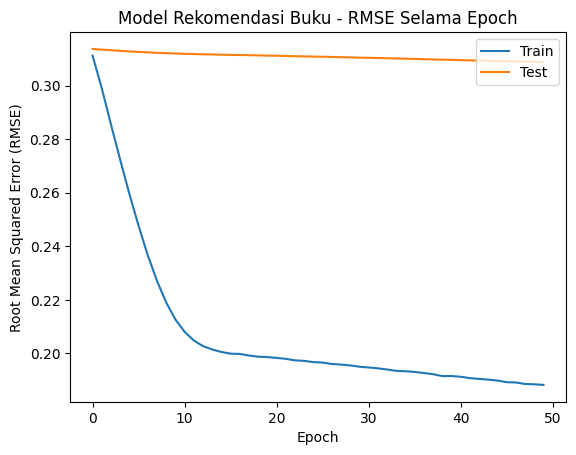

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Rekomendasi Buku - RMSE Selama Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Grafik RMSE selama epoch menunjukkan performa model rekomendasi buku. RMSE pada data training turun dari sekitar 0.31 ke 0.19, menandakan model belajar dengan baik. Namun, RMSE pada data testing tetap stabil di sekitar 0.31, mengindikasikan sedikit overfitting dan keterbatasan generalisasi. Meski demikian, perbedaan nilai RMSE yang kecil menunjukkan model sudah cukup baik. Untuk perbaikan, dapat dilakukan regularisasi lebih kuat, penyesuaian dropout, atau menambah data pelatihan.
